# Assignment 2: Disney stocks

## Plotting closing prices

In [3]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 1, 30)
dis = web.DataReader('DIS', 'yahoo', start, end)
dis.head(10) 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,32.750000,31.870001,32.500000,32.070000,13700400.0,27.933924
2010-01-05,32.160000,31.700001,32.070000,31.990000,10307700.0,27.864237
2010-01-06,32.000000,31.680000,31.900000,31.820000,10709500.0,27.716166
2010-01-07,31.860001,31.540001,31.770000,31.830000,8202100.0,27.724878
2010-01-08,31.940001,31.530001,31.660000,31.879999,7657500.0,27.768419
2010-01-11,31.740000,31.090000,31.530001,31.360001,11250500.0,27.315489
2010-01-12,31.120001,30.680000,31.020000,30.820000,14618300.0,26.845137
2010-01-13,31.370001,30.870001,30.889999,31.290001,9620600.0,27.254517
2010-01-14,31.180000,30.959999,31.129999,31.020000,9235600.0,27.019341


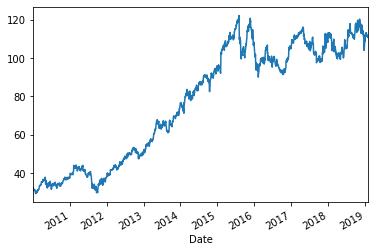

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
high = dis['High']
high.grid = True
high.plot()

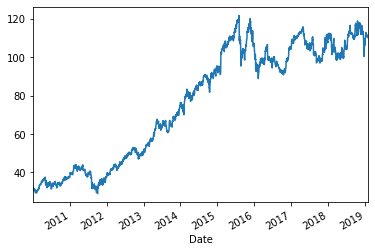

In [6]:
close = dis['Close']
close.grid = True
close.plot()

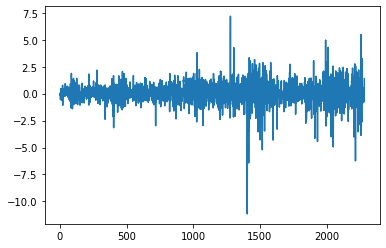

In [7]:
import numpy as np
returns = np.diff(close)
plt.grid = True
plt.plot(returns)

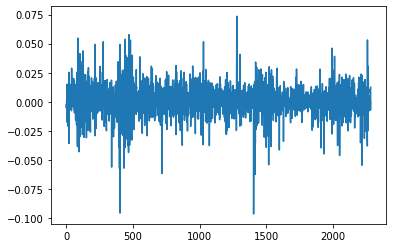

In [8]:
import numpy as np
returns = np.diff(np.log(close))
plt.grid = True
plt.plot(returns)

In [9]:
high.corr(close)
# a value of 0.3 essentially means little correlation..

0.9998237753556719

# 1. Exploratory Data Analysis(EDA)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

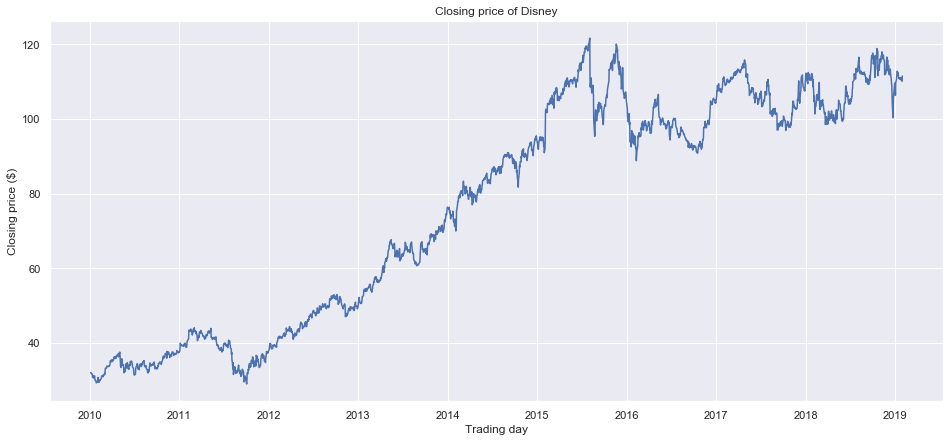

In [12]:
# Plot closing price
plt.figure(figsize=(16, 7))
plt.plot(dis.Close)
plt.title('Closing price of Disney')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')

plt.show()

# 2. Moving Average

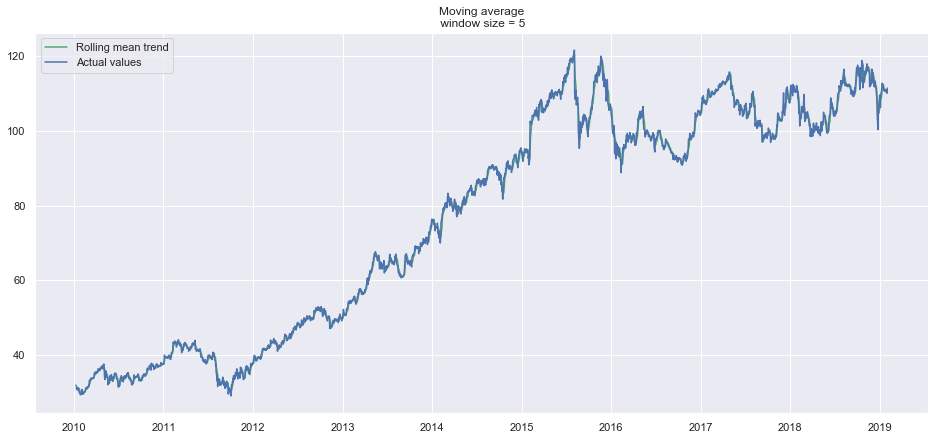

In [14]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(16,7))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    

#Smooth by the previous 5 days (by week)
plot_moving_average(dis.Close, 5)

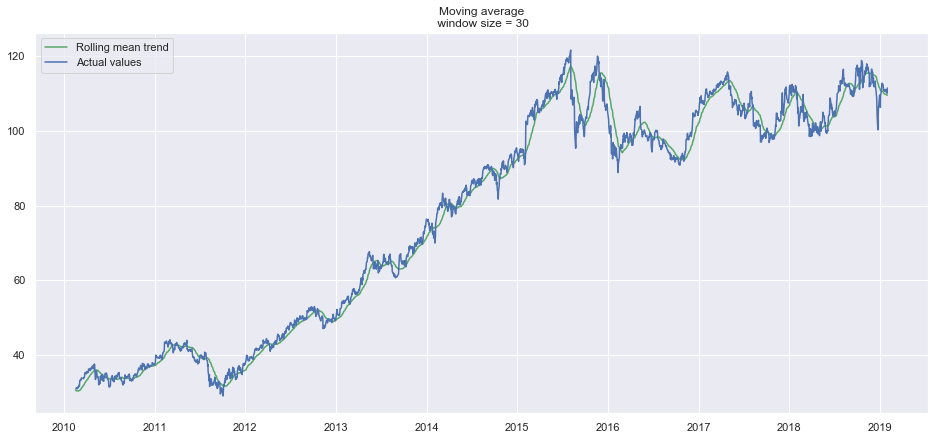

In [15]:
#Smooth by the previous month
plot_moving_average(dis.Close, 30)

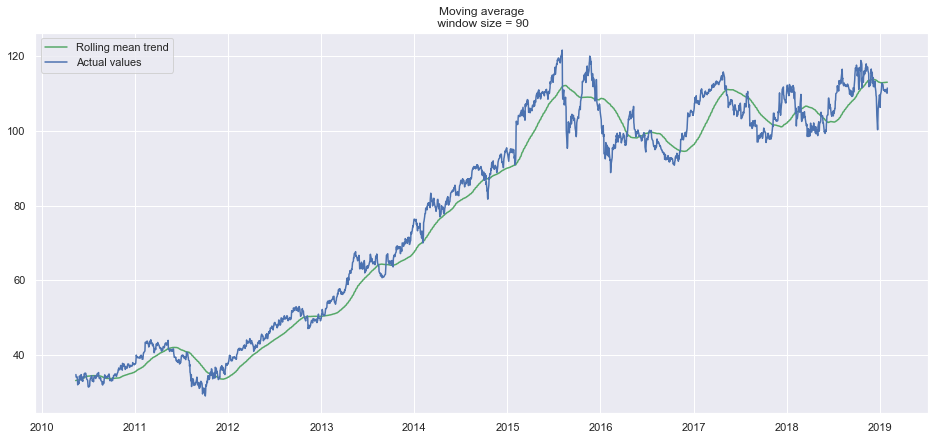

In [16]:
#Smooth by the previous quarter
plot_moving_average(dis.Close, 90)

# 3. Exponential Smoothing

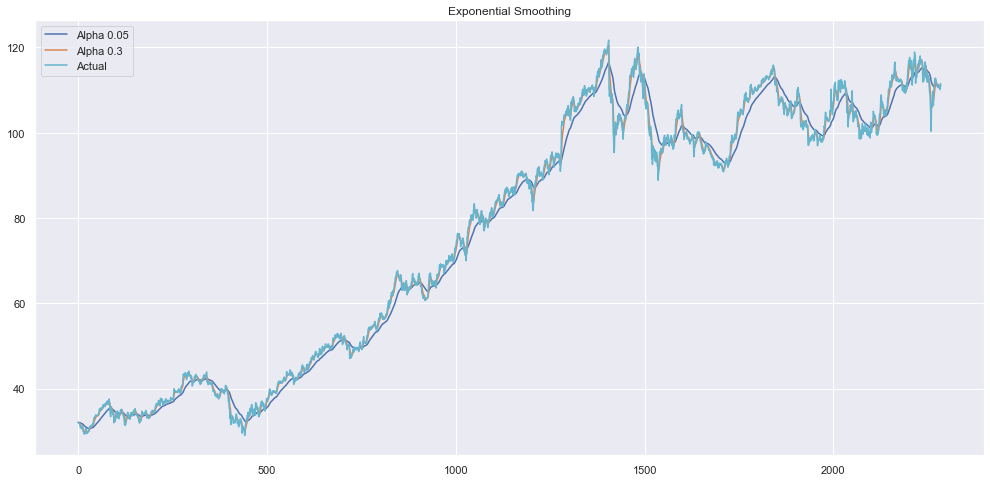

In [18]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    
        
plot_exponential_smoothing(dis.Close, [0.05, 0.3])

# 4. Double Exponential Smoothing

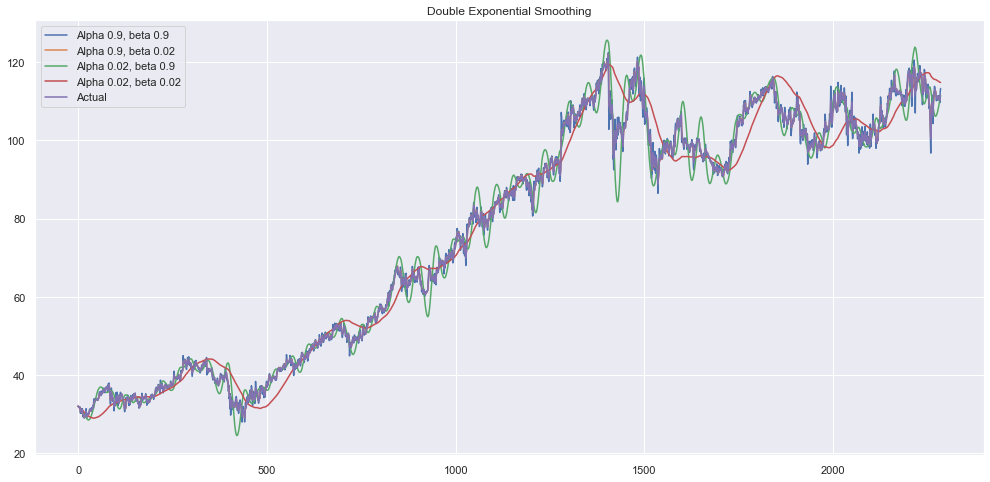

In [20]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    
plot_double_exponential_smoothing(dis.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# 5. Modeling

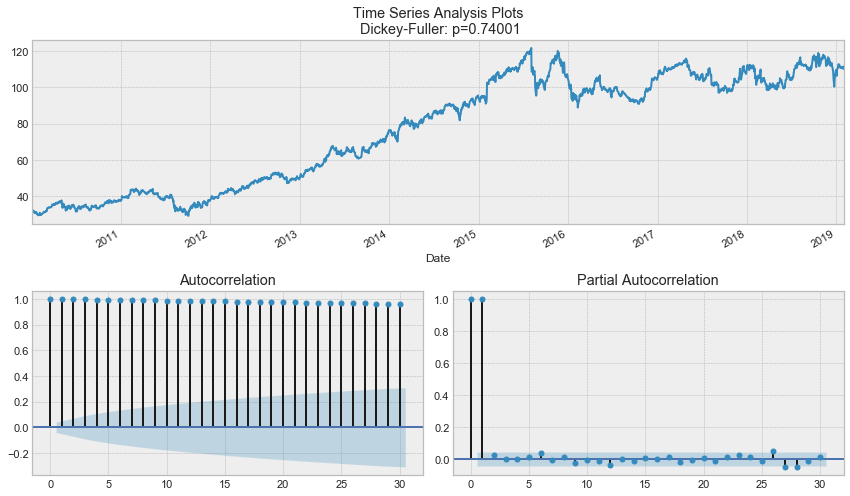

In [21]:
import statsmodels as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(dis.Close, lags=30)

# 6. Prediction of Stock using Random Forest

In [22]:
dis.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,32.750000,31.870001,32.50,32.070000,13700400.0,27.933924
2010-01-05,32.160000,31.700001,32.07,31.990000,10307700.0,27.864237
2010-01-06,32.000000,31.680000,31.90,31.820000,10709500.0,27.716166
2010-01-07,31.860001,31.540001,31.77,31.830000,8202100.0,27.724878
2010-01-08,31.940001,31.530001,31.66,31.879999,7657500.0,27.768419


In [24]:
dfreg = dis.loc[:,['Adj Close', 'Volume']]
dfreg['HighLow_PCT'] = (dis['High'] - dis['Low']) / dis['Close'] * 100.0
dfreg['PCT_change'] = (dis['Close'] - dis['Open']) / dis['Open'] * 100.0
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change
Date,,,,
2010-01-04,27.933924,13700400.0,2.743995,-1.323078
2010-01-05,27.864237,10307700.0,1.437947,-0.249454
2010-01-06,27.716166,10709500.0,1.005656,-0.250783
2010-01-07,27.724878,8202100.0,1.005340,0.188856
2010-01-08,27.768419,7657500.0,1.286072,0.694881
...,...,...,...,...
2019-01-25,109.748734,5706900.0,0.756140,-0.340903
2019-01-28,109.472115,6178800.0,0.938544,0.045139
2019-01-29,109.561035,5253700.0,0.838594,0.225938


In [25]:
dfreg.fillna(value=-99999, inplace=True)

In [26]:
import math
forecast = int(math.ceil(0.352 * len(dfreg)))
forecast

805

In [27]:
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast)
X = np.array(dfreg.drop(['label'], 1))
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2010-01-04,27.933924,13700400.0,2.743995,-1.323078,51.663746
2010-01-05,27.864237,10307700.0,1.437947,-0.249454,51.191025
2010-01-06,27.716166,10709500.0,1.005656,-0.250783,51.763752
2010-01-07,27.724878,8202100.0,1.005340,0.188856,51.191025
2010-01-08,27.768419,7657500.0,1.286072,0.694881,51.618286
...,...,...,...,...,...
2019-01-25,109.748734,5706900.0,0.756140,-0.340903,NaN
2019-01-28,109.472115,6178800.0,0.938544,0.045139,NaN
2019-01-29,109.561035,5253700.0,0.838594,0.225938,NaN


In [28]:
dfreg.tail(700)

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2016-04-21,97.089737,6824800.0,1.428434,-0.435369,NaN
2016-04-22,97.901100,5731300.0,1.021488,0.688918,NaN
2016-04-25,98.655853,6117100.0,1.214502,1.033816,NaN
2016-04-26,98.957764,6452900.0,1.325197,0.296421,NaN
2016-04-27,99.325691,5996100.0,0.797869,0.085556,NaN
...,...,...,...,...,...
2019-01-25,109.748734,5706900.0,0.756140,-0.340903,NaN
2019-01-28,109.472115,6178800.0,0.938544,0.045139,NaN
2019-01-29,109.561035,5253700.0,0.838594,0.225938,NaN


In [29]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [30]:
X_lately = X[-forecast:]
X = X[:-forecast]
X

array([[-1.46556709,  1.00334629,  1.27844703, -1.30729867],
       [-1.46790634,  0.3121737 , -0.19695843, -0.27141647],
       [-1.47287679,  0.39402979, -0.68530477, -0.27269912],
       ...,
       [ 1.21050379, -0.14204813,  0.18536628, -0.92965845],
       [ 1.24448894, -0.61222151,  0.84884315,  2.05252487],
       [ 1.25109743, -0.47690839,  0.163075  , -0.01411482]])

In [31]:
import numpy as np
y = np.array(dfreg['label'])
y
y = y[:-forecast]
y

array([ 51.66374588,  51.19102478,  51.76375198, ..., 109.56103516,
       108.80033112, 110.17354584])

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
rf_model = RandomForestRegressor()

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
rf_model.score(X_test, y_test)

0.7344700914159985

In [36]:
dfreg.tail(806)

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2015-11-17,108.864212,6434400.0,1.756653,0.017222,110.173546
2015-11-18,110.748451,6744600.0,1.887587,1.652038,NaN
2015-11-19,111.282791,6101000.0,1.280435,0.482478,NaN
2015-11-20,112.557701,10821700.0,1.124343,0.805977,NaN
2015-11-23,111.948364,6986400.0,1.381679,-0.731509,NaN
...,...,...,...,...,...
2019-01-25,109.748734,5706900.0,0.756140,-0.340903,NaN
2019-01-28,109.472115,6178800.0,0.938544,0.045139,NaN
2019-01-29,109.561035,5253700.0,0.838594,0.225938,NaN


After going 806 days in the past, we can predict the future by maintaining 71% accuracy